# Analysis for Li, 2023
Gene expression data from two datasets (GSE20916 and GSE8671) were analyzed in Python, primarily using the pandas (McKinney, 2010), matplotlib (Hunter, 2007), seaborn (Waskom et al., 2021), scipy (Virtanen et al., 2020), and statsmodels (Seabold, Skipper, and Josef Perktold, 2010) libraries.

Seven genes of interest were selected for detailed analysis. For visualization, boxplots were generated to compare expression values between "Normal" and "Adenoma" samples.

Log2 Fold Change, effect size (as rank-biserial correlation), and Benjamini-Hochberg adjusted Wilcoxon rank-sum test were calculated for each gene in each dataset.

In [1]:
%%capture 
# Hide matplotlib backend error

import os
import pandas as pd 
from sklearn import preprocessing
from math import sqrt
from statistics import mean, stdev
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import GEOparse
import xpressplot as xp

sns.set(font='arial')
_jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

%matplotlib inline

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + os.path.sep

In [2]:
print(__path__)

/mnt/c/Users/jorda/Desktop/li_2021/


In [3]:
test_genes = [
    'SPTLC1',
    'SPTLC2',
    'CERS6',
    'DEGS1',
    'DEGS2',
    'SGMS1',
    'SGMS2'
]

# GEO Microarray data

### Read data for GSE8671

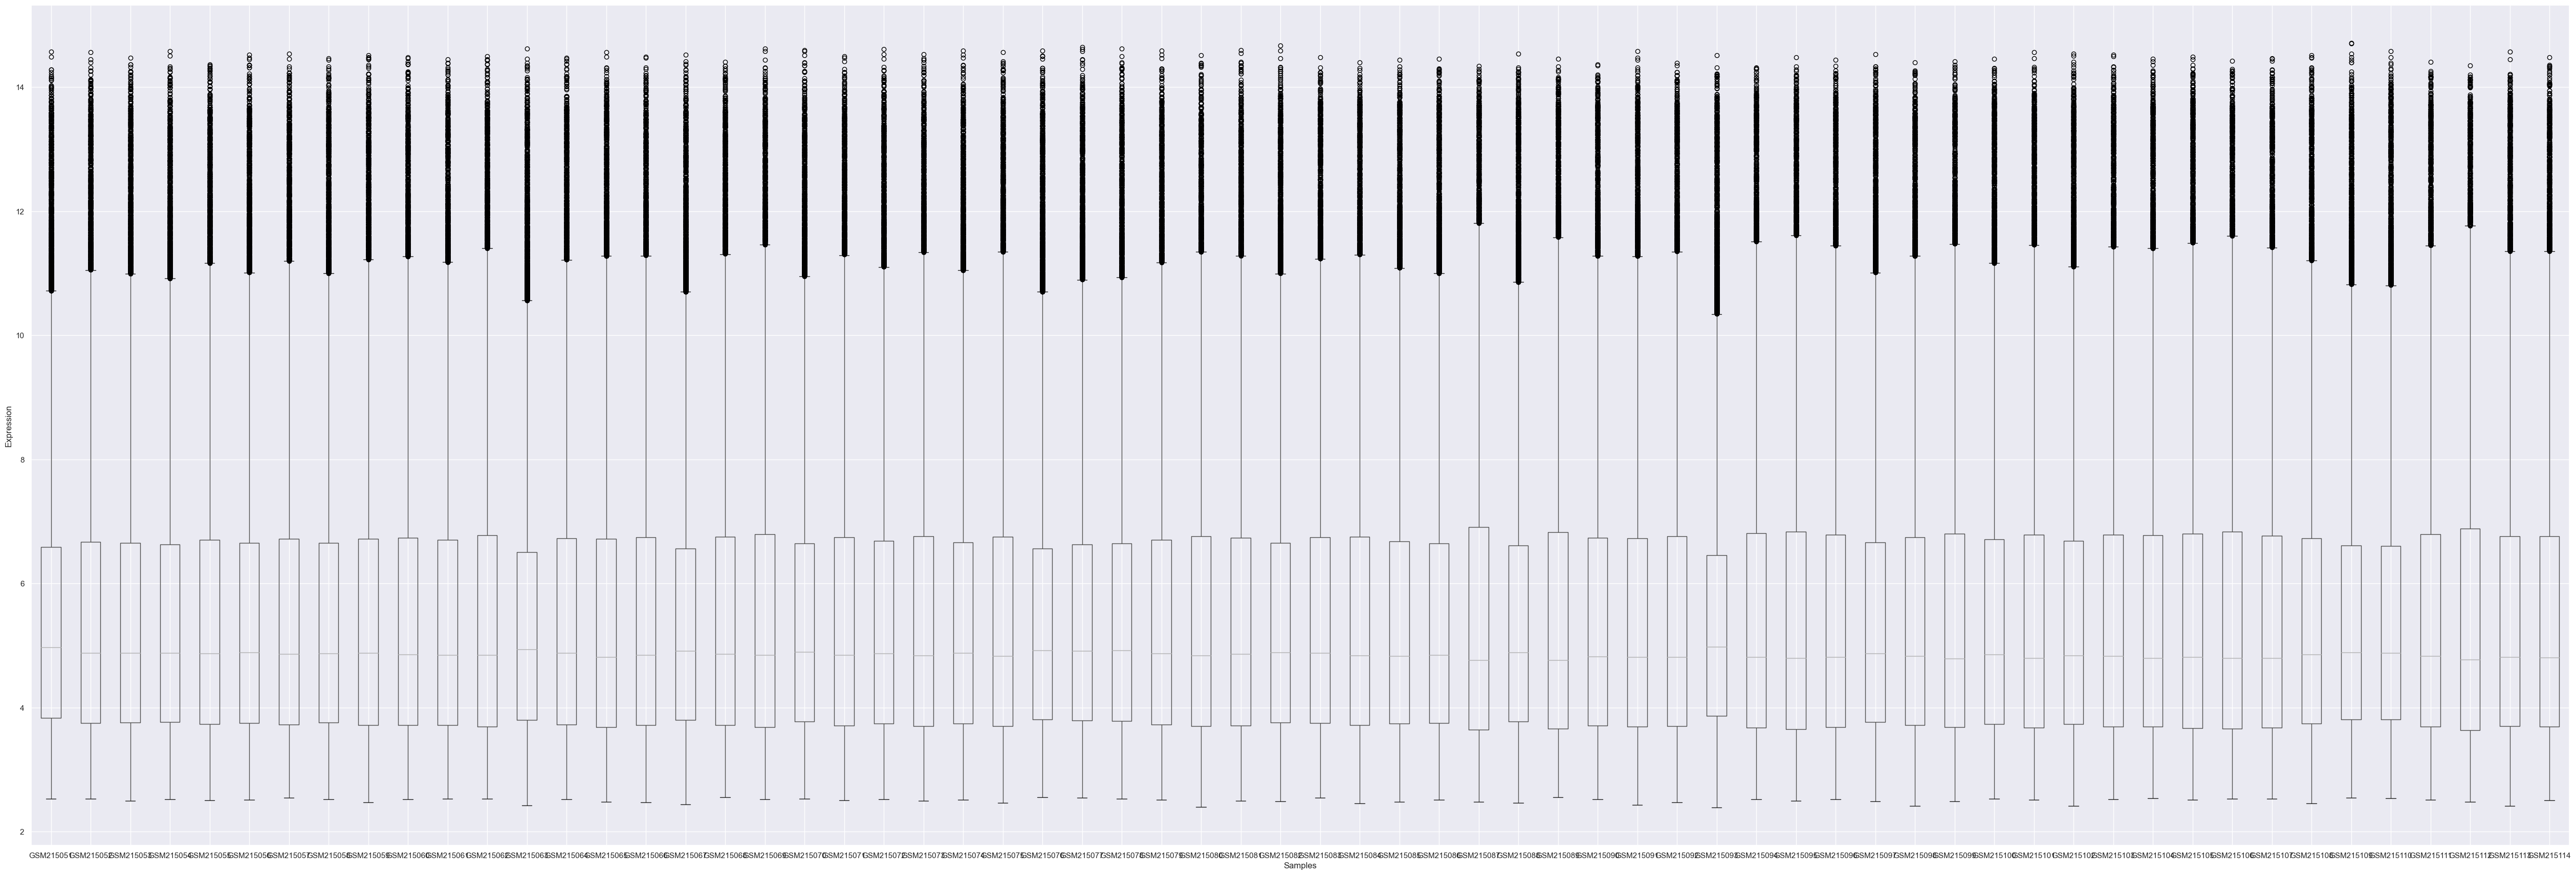

In [5]:
#Get data
df_GSE8671 = xp.get_df(__path__ + 'data/GSE8671_rma_normalized.zip', delimiter=',') #RMA normalized with Alt Analyze
info_GSE8671 = xp.get_info(__path__ + "data/sample_info_gse8671.csv", delimiter=',')
df_GSE8671_c = xp.keep_labels(df_GSE8671, info_GSE8671, label_list=['Normal','Adenoma'])
df_GSE8671_clean = xp.clean_df(df_GSE8671_c)

#Collapse multi-mapping probes
df_GSE8671_collapsed = xp.probe_collapse(df_GSE8671_clean, __path__ + "data/GPL570.zip")
df_GSE8671_collapsed.to_csv(__path__ + "data" + os.path.sep + "collapsed_GSE8671.csv",sep=',')

#Scale dataset
df_GSE8671_scaled, df_GSE8671_labeled = xp.prep_data(df_GSE8671_collapsed, info_GSE8671)

#sort by sample labels
info_GSE8671_sorted = info_GSE8671.copy()
info_GSE8671_sorted = info_GSE8671_sorted.loc[info_GSE8671_sorted[1].isin(['Adenoma', 'Normal'])]
info_GSE8671_sorted = info_GSE8671_sorted.sort_values([1], ascending=False)
info_GSE8671_sorted_list = info_GSE8671_sorted[0].tolist()
df_GSE8671_scaled_sorted = df_GSE8671_scaled[info_GSE8671_sorted_list]

#set palette
gse8671_colors = {'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

xp.check_samples(df_GSE8671_clean)

### Read data for GSE20916

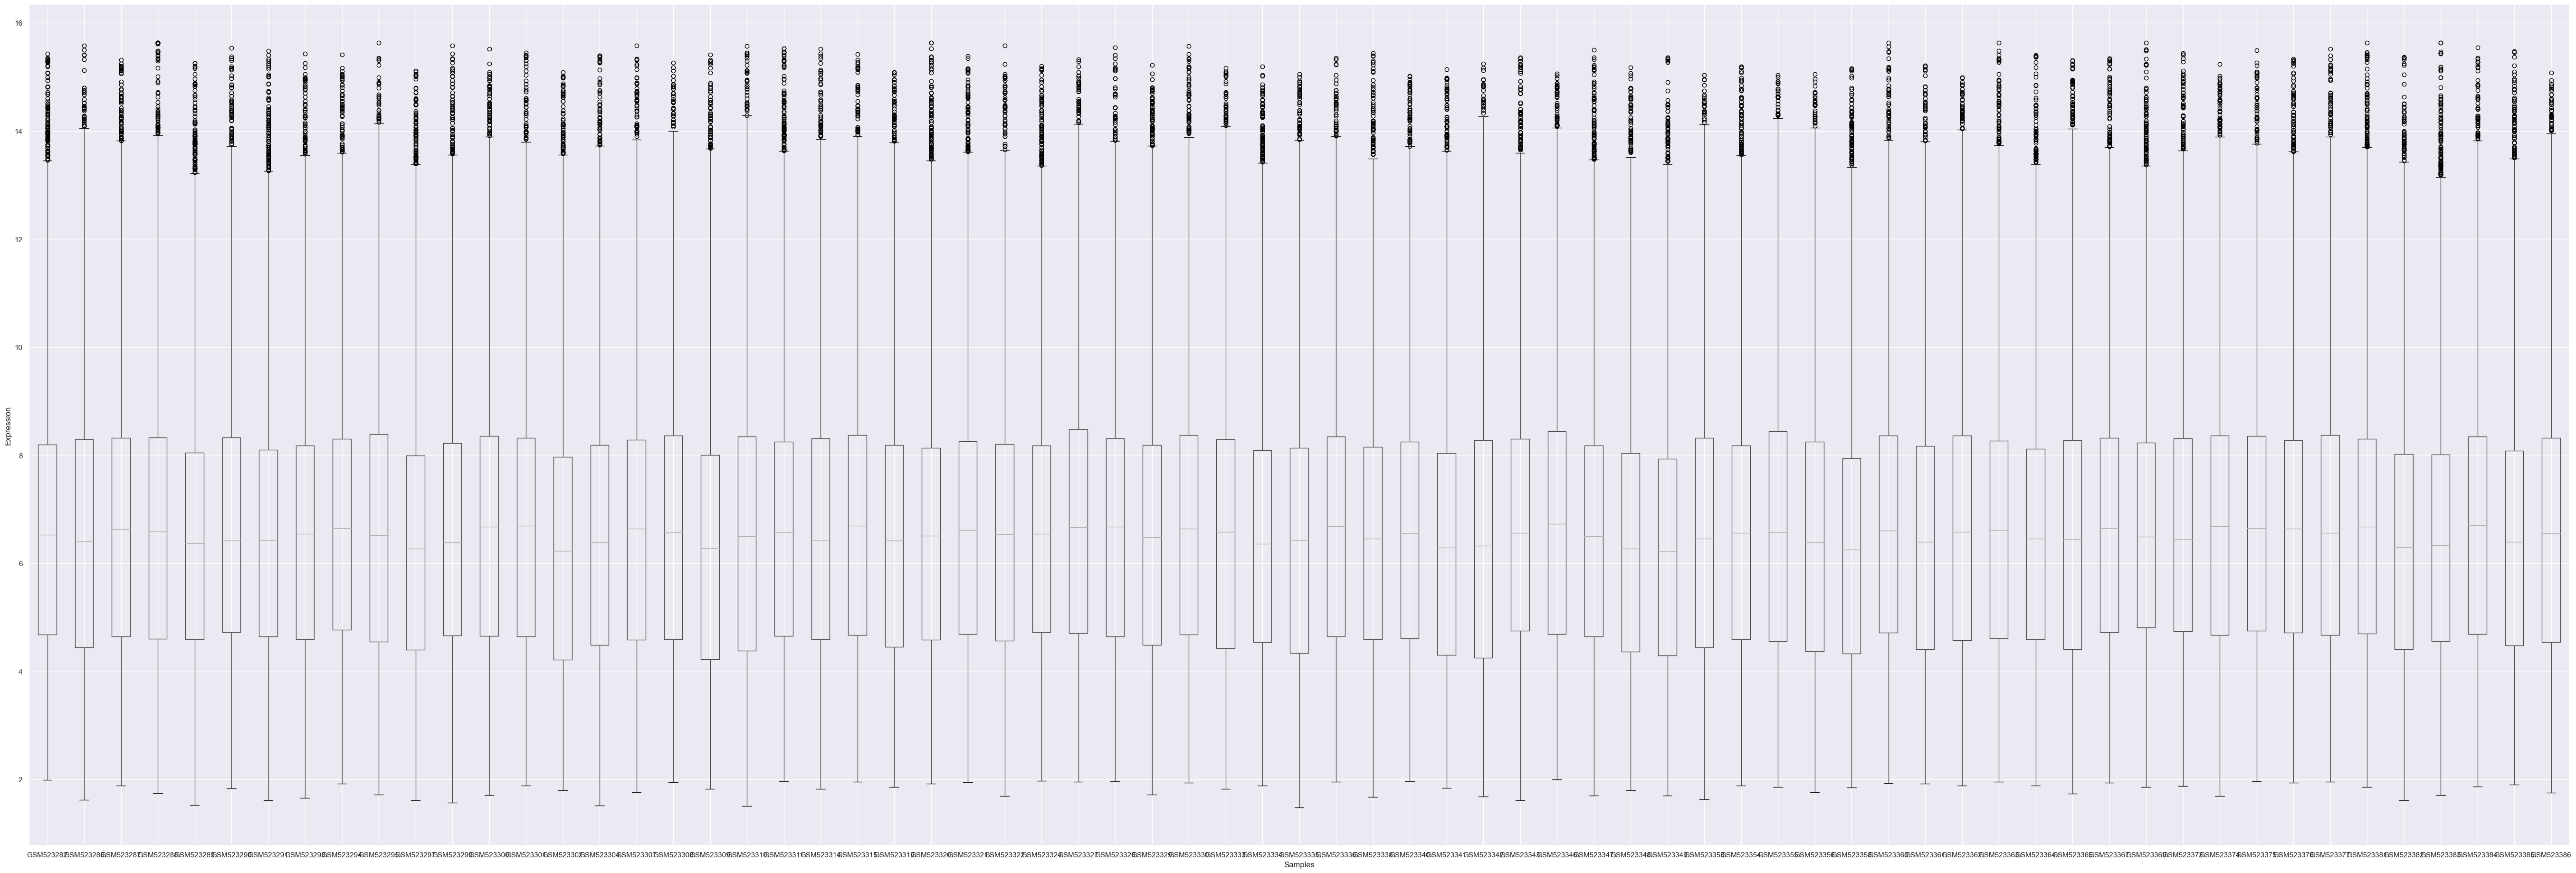

In [6]:
def get_geo(
    geo_id,
    output_info=False, output_path="./"):

    # Get data
    gse = GEOparse.get_GEO(geo=str(geo_id).upper(), destdir=output_path) # Import GSE dataset

    data = gse.pivot_samples('VALUE')
    data = xp.clean_df(data)

    # Get metadata
    # Write data to output file
    if output_info != False:
        with open(str(geo_id).upper() + '.txt', 'w+') as f: # Save all information as text file for reference
            for gsm_name, gsm in gse.gsms.items():
                f.write(gsm_name + '\n')
                for key, value in gsm.metadata.items():
                    f.write(" - %s : %s" % (key, ", ".join(value)) + '\n')

    # Populate metadata with sample ids and names
    metadata = pd.DataFrame(columns=['gsm', 'title']) # Create dataframe
    gsm_list, title_list, data_processing_list = [], [], []
    for gsm_name, gsm in gse.gsms.items():
        for key, value in gsm.metadata.items():
            if key == 'title':
                title_list.append(''.join(value))
            if key == 'geo_accession':
                gsm_list.append(''.join(value))
            if key == 'data_processing':
                data_processing_list.append(''.join(value))

    metadata['gsm'], metadata['title'] = gsm_list, title_list
    metadata.columns = range(metadata.shape[1])

    # Output processing style
    print('Data processing summary:\n' + str(set(data_processing_list))) # To determine if all samples have undergone the sample data processing

    # Clean data
    del data.columns.name
    del data.index.name

    # Clean metadata
    metadata[1] = metadata[1].apply(lambda x: x[0:(re.search("\d", x).start()) - 1])

    return data, metadata

# Get data from GEO database 
#df_GSE20916, info_GSE20916 = get_geo('GSE20916')

#df_GSE20916.to_csv(__path__ + "data/GSE20916_normalized.csv", sep=',')
#info_GSE20916.to_csv(__path__ + "data/sample_info_gse20916.csv", sep=',', index=False)

#Get data
df_GSE20916 = pd.read_csv(__path__ + "data" + os.path.sep + "GSE20916_normalized.zip", index_col=0)
info_GSE20916 = pd.read_csv(__path__ + "data" + os.path.sep + "sample_info_gse20916.csv")
info_GSE20916.columns = [0,1]
info_GSE20916[1] = info_GSE20916[1].str.capitalize() #Make sample types look nice
info_GSE20916 = info_GSE20916.replace('Normal_colon', 'Normal')
df_GSE20916_c = xp.keep_labels(df_GSE20916, info_GSE20916, label_list=['Normal','Adenoma'])
df_GSE20916_clean = xp.clean_df(df_GSE20916_c)

#Collapse multi-mapping probes
df_GSE20916_collapsed = xp.probe_collapse(df_GSE20916_clean, __path__ + "data" + os.path.sep + "GPL570.zip")
df_GSE20916_collapsed.to_csv(__path__ + "data" + os.path.sep + "collapsed_GSE20916.txt",sep='\t')

#Scale sorted dataset
df_GSE20916_scaled, df_GSE20916_labeled = xp.prep_data(df_GSE20916_collapsed, info_GSE20916)

#sort by sample labels
info_GSE20916_sorted = info_GSE20916.copy()
info_GSE20916_sorted = info_GSE20916_sorted.loc[info_GSE20916_sorted[1].isin(['Adenoma','Normal'])]
info_GSE20916_sorted = info_GSE20916_sorted.sort_values([1], ascending=False)
info_GSE20916_sorted_list = info_GSE20916_sorted[0].tolist()
df_GSE20916_scaled_sorted = df_GSE20916_scaled[info_GSE20916_sorted_list]

gse20916_colors = {
        'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

xp.check_samples(df_GSE20916_clean)

### Heatmap for GSE8671

<Figure size 640x480 with 0 Axes>

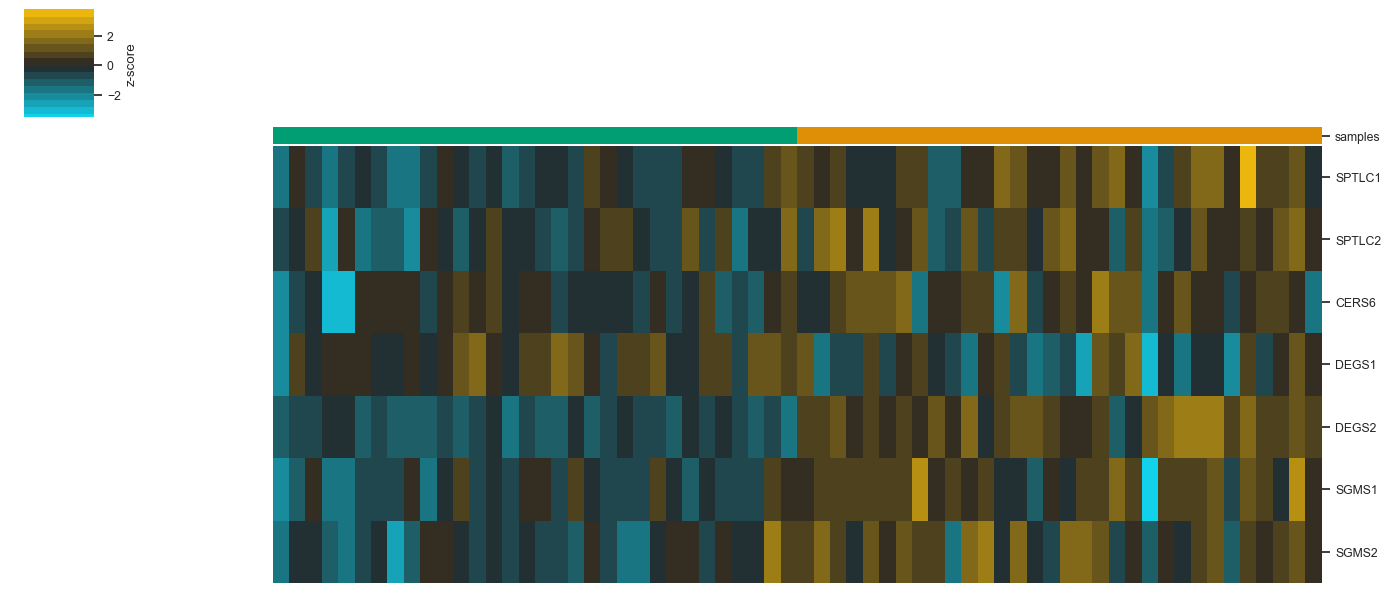

In [7]:
xp.heatmap(
    df_GSE8671_scaled_sorted, 
    info_GSE8671, 
    sample_palette=gse8671_colors, 
    gene_list=test_genes, 
    figsize=(14,6), 
    save_fig=(__path__ + "plots" + os.path.sep + "GSE8671_heatmap.pdf"),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE8671_scaled_sorted, 
    info_GSE8671, 
    sample_palette=gse8671_colors, 
    gene_list=test_genes, 
    figsize=(14,6), 
    save_fig=(__path__ + "plots" + os.path.sep + "GSE8671_heatmap.png"),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE8671_scaled_sorted, 
    info_GSE8671, 
    sample_palette=gse8671_colors, 
    gene_list=test_genes, 
    figsize=(14,6), 
    save_fig=(__path__ + "plots" + os.path.sep + "GSE8671_heatmap.svg"),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

### Heatmap for GSE20916

<Figure size 640x480 with 0 Axes>

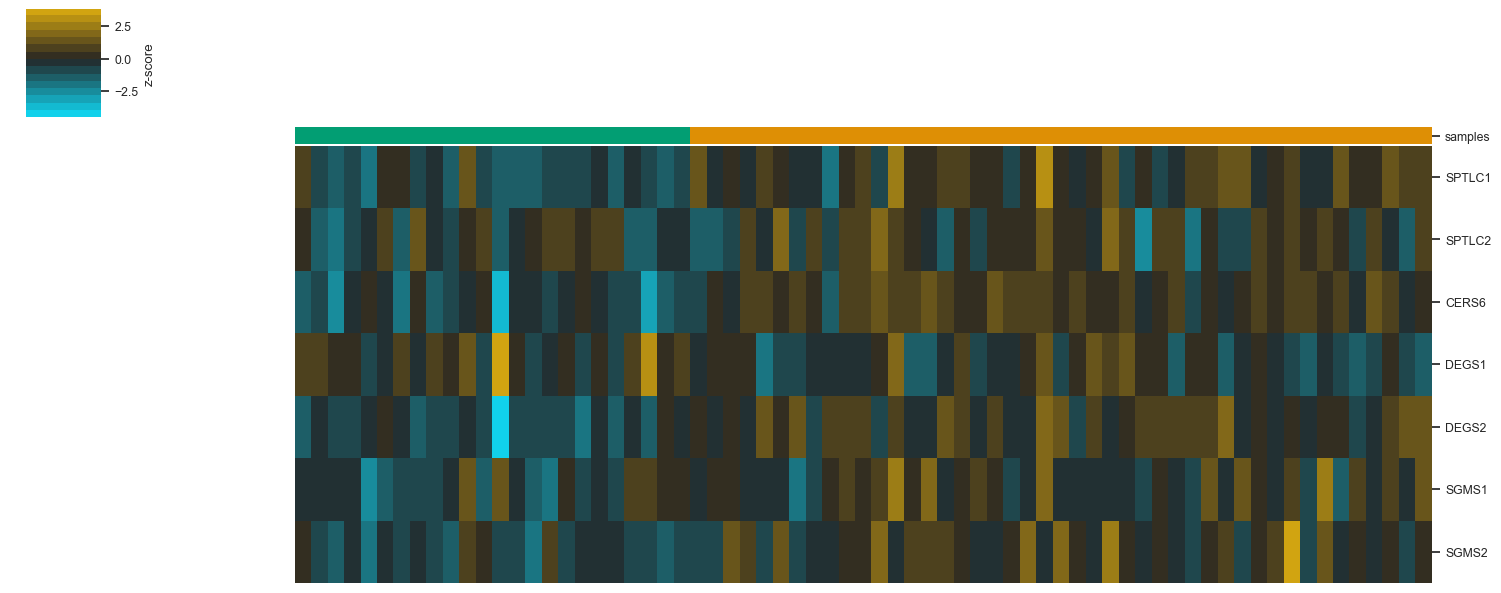

In [8]:
xp.heatmap(
    df_GSE20916_scaled_sorted, 
    info_GSE20916, 
    sample_palette=gse20916_colors, 
    gene_list=test_genes, 
    figsize=(15.1,6), 
    save_fig=(__path__ + 'plots/GSE20916_heatmap.pdf'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE20916_scaled_sorted, 
    info_GSE20916, 
    sample_palette=gse20916_colors, 
    gene_list=test_genes, 
    figsize=(15.1,6), 
    save_fig=(__path__ + 'plots/GSE20916_heatmap.png'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE20916_scaled_sorted, 
    info_GSE20916, 
    sample_palette=gse20916_colors, 
    gene_list=test_genes, 
    figsize=(15.1,6), 
    save_fig=(__path__ + 'plots/GSE20916_heatmap.svg'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

## Boxplots

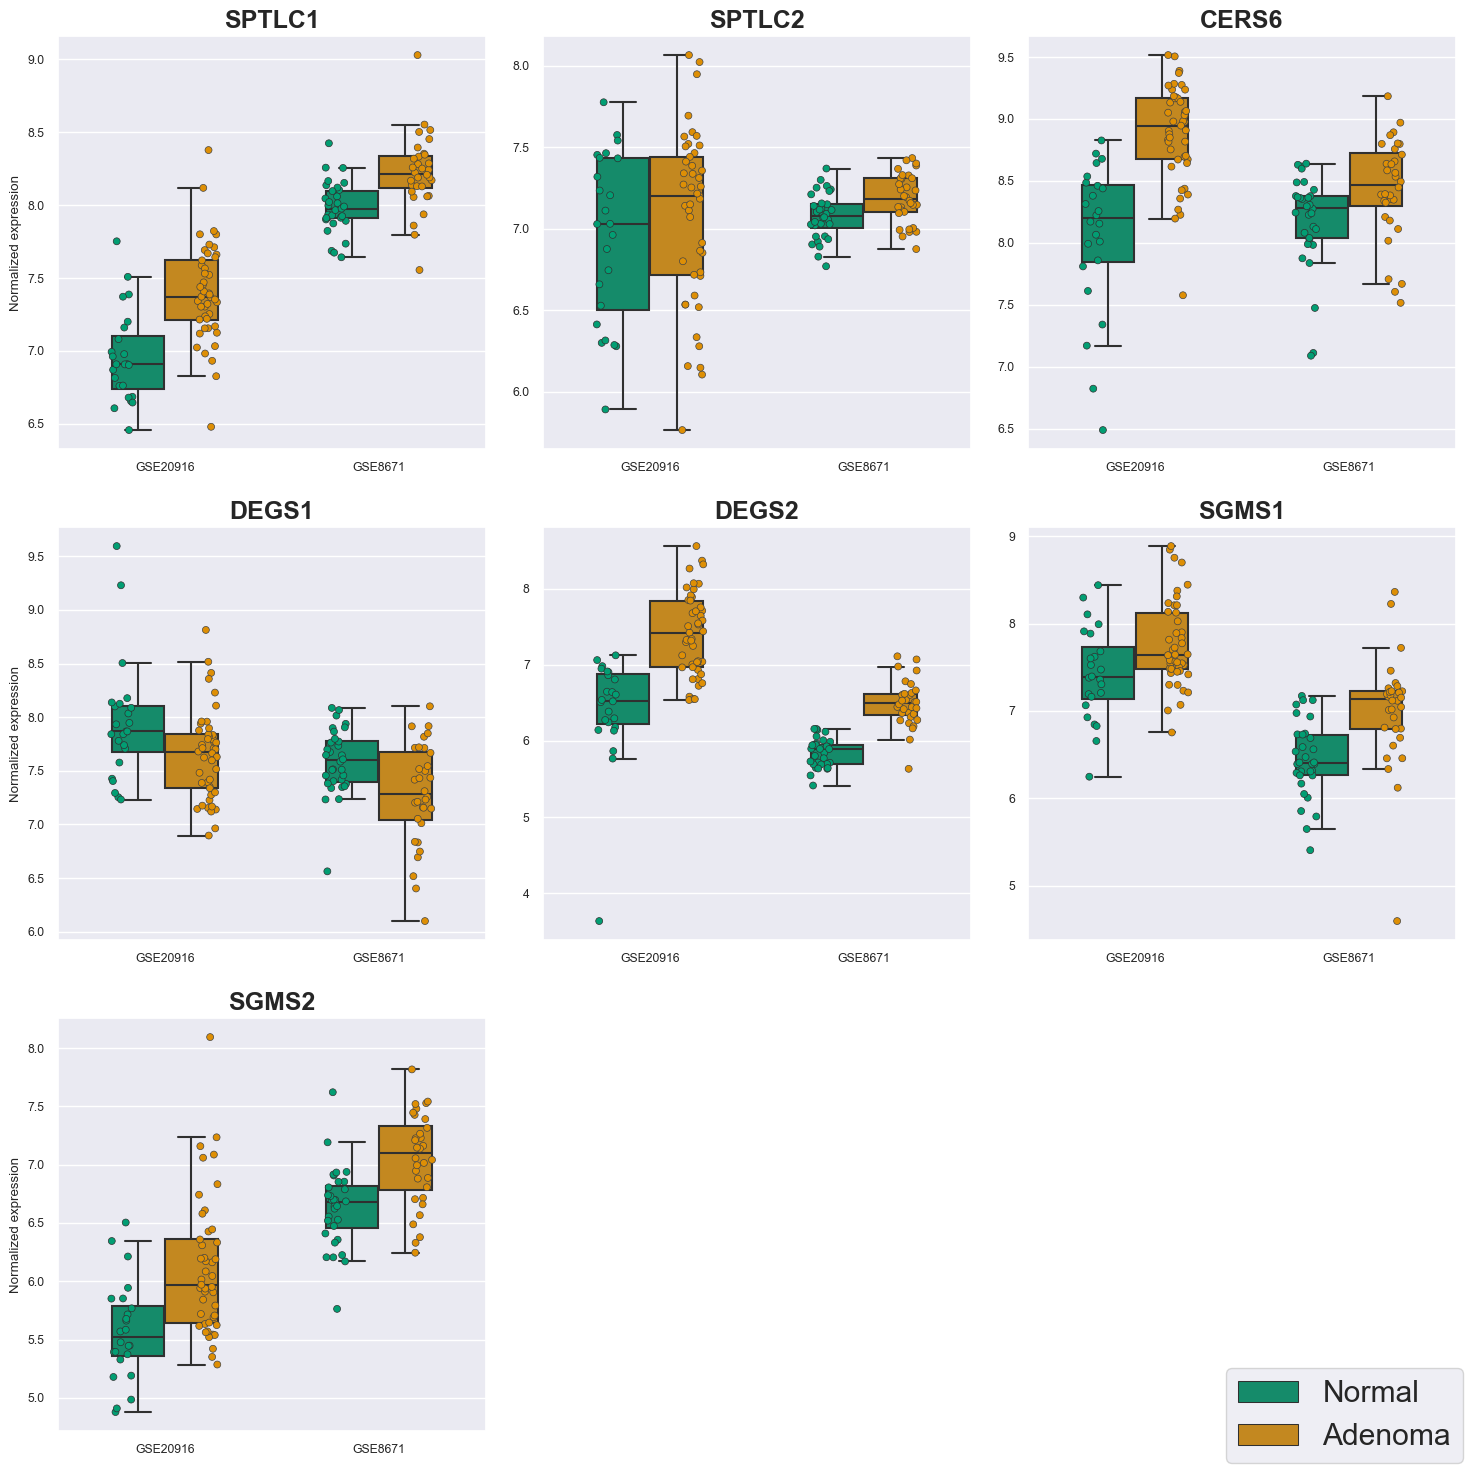

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your color dictionary
color_dict = {
    'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)
}

# Your genes of interest
genes_of_interest = ['SPTLC1', 'SPTLC2', 'CERS6', 'DEGS1', 'DEGS2', 'SGMS1', 'SGMS2']

# Prepare an empty dataframe to store melted dataframes
df_melted_combined = pd.DataFrame()

# Iterate over both datasets
for dataset in ["GSE20916", "GSE8671"]:
    # Restrict to genes of interest
    df = globals()[f'df_{dataset}_collapsed'].loc[genes_of_interest]
    
    # Transpose the dataframe so columns are genes and rows are sampleIDs
    df = df.transpose()

    # Add sample type information
    info = globals()[f'info_{dataset}']
    info.columns = ['SampleID', 'Type']  # make sure the info dataframe has column names
    df = df.join(info.set_index('SampleID'))

    # Melt dataframe so that each row corresponds to one measurement
    df_melted = df.melt(id_vars='Type', var_name='Gene', value_name='Expression')
    df_melted['Dataset'] = dataset  # Add dataset identifier to the dataframe

    # Concatenate current melted dataframe with the combined one
    df_melted_combined = pd.concat([df_melted_combined, df_melted])

# Decide the grid size (i by j)
i = 3
j = 3

# Set overall figure dimensions (width, height)
fig_dims = (15, 15)

# Create subplots
fig, axs = plt.subplots(i, j, figsize=fig_dims)
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # increase spacing between plots

# Increase font size
sns.set(font_scale=1.5)

# Turn off unused plots
for ax in axs.flatten()[len(genes_of_interest):]:
    ax.axis('off')

for idx, (ax, gene) in enumerate(zip(axs.flatten(), genes_of_interest)):
    df_gene = df_melted_combined[df_melted_combined['Gene'] == gene]
    sns.boxplot(x='Dataset', y='Expression', hue='Type', data=df_gene, ax=ax, palette=color_dict, showfliers=False, width=0.5, dodge=True)
    sns.stripplot(x='Dataset', y='Expression', hue='Type', data=df_gene, dodge=True, linewidth=0.5, ax=ax, palette=color_dict)
    ax.set_title(gene, fontweight='bold')  # make the gene names bold
    ax.get_legend().remove()  # remove legend from each subplot
    ax.set_xlabel('')
    if idx % j == 0:  # First column
        ax.set_ylabel('Normalized expression')
    else:
        ax.set_ylabel('')

# Add a common legend
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc='lower right', fontsize='large')  # add legend back to the figure, only for two categories

plt.tight_layout()
plt.savefig("figure_grid_genes.png", dpi=600)  # for PNG
plt.savefig("figure_grid_genes.pdf", format='pdf')  # for PDF
plt.show()

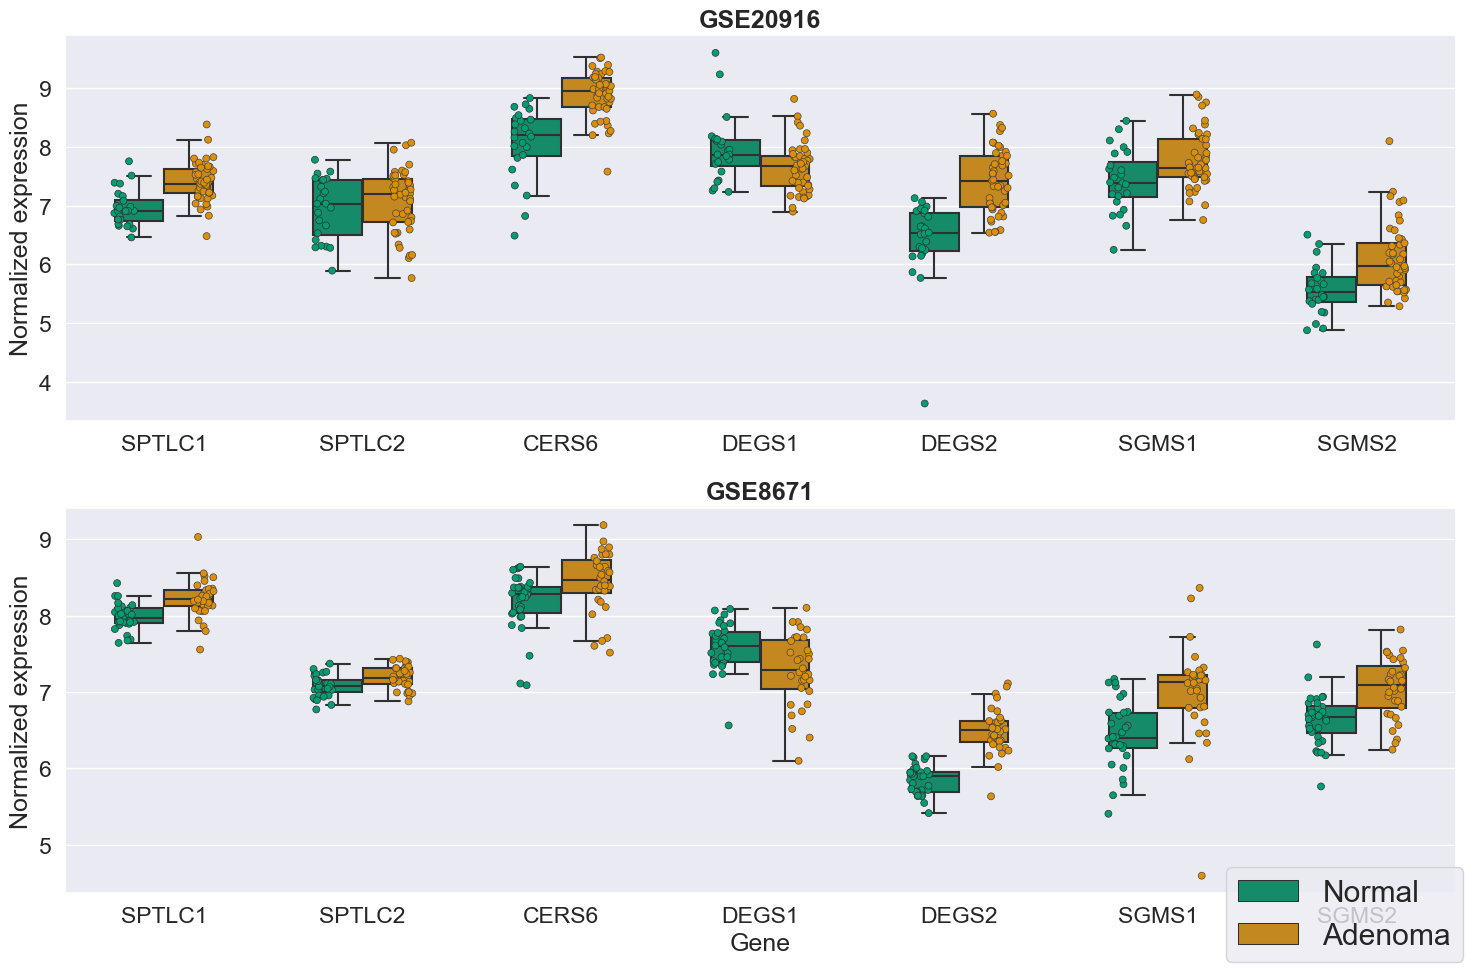

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your color dictionary
color_dict = {
    'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)
}

# Your genes of interest
genes_of_interest = ['SPTLC1', 'SPTLC2', 'CERS6', 'DEGS1', 'DEGS2', 'SGMS1', 'SGMS2']

# Set overall figure dimensions (width, height)
fig_dims = (15, 10)

# Decide the grid size (i by j)
i = 2
j = 1

# Create subplots
fig, axs = plt.subplots(i, j, figsize=fig_dims)
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # increase spacing between plots

# Increase font size
sns.set(font_scale=1.5)

# Iterate over both datasets and plot in separate rows
for dataset_idx, dataset in enumerate(["GSE20916", "GSE8671"]):
    # Restrict to genes of interest
    df = globals()[f'df_{dataset}_collapsed'].loc[genes_of_interest]
    
    # Transpose the dataframe so columns are genes and rows are sampleIDs
    df = df.transpose()

    # Add sample type information
    info = globals()[f'info_{dataset}']
    info.columns = ['SampleID', 'Type']  # make sure the info dataframe has column names
    df = df.join(info.set_index('SampleID'))

    # Melt dataframe so that each row corresponds to one measurement
    df_melted = df.melt(id_vars='Type', var_name='Gene', value_name='Expression')

    ax = axs[dataset_idx]
    sns.boxplot(x='Gene', y='Expression', hue='Type', data=df_melted, ax=ax, palette=color_dict, showfliers=False, width=0.5, dodge=True)
    sns.stripplot(x='Gene', y='Expression', hue='Type', data=df_melted, dodge=True, linewidth=0.5, ax=ax, palette=color_dict)
    ax.set_title(dataset, fontweight='bold')  # make the dataset name bold
    ax.get_legend().remove()  # remove legend from each subplot
    if dataset_idx == i - 1:  # Only for the last plot
        ax.set_xlabel('Gene')
    else:
        ax.set_xlabel('')
    ax.set_ylabel('Normalized expression')

# Add a common legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc='lower right', fontsize='large')  # add legend back to the figure, only for two categories

plt.tight_layout()
plt.savefig("figure_grid_datasets.png", dpi=600)  # for PNG
plt.savefig("figure_grid_datasets.pdf", format='pdf')  # for PDF
plt.show()

## Effect size analysis
General interpretation:

**Small effect size (0.1 - 0.3)**: There is a difference between groups, but it may not be meaningful in a practical sense. The two groups overlap quite a bit. Small effect sizes can still be important if the variable being studied is significant.

**Medium effect size (0.3 - 0.5)**: There is a moderate difference between groups. This would be noticeable and could be of practical significance depending on the context.

**Large effect size (Above 0.5)**: There is a substantial difference between groups. In many contexts, an effect size of this magnitude would be considered of practical significance.

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import multitest

def calc_fc_and_fdr(df, info, genes_of_interest):
    result = []
    
    # join type info to the dataframe
    info.columns = ['SampleID', 'Type']
    df = df.transpose().join(info.set_index('SampleID'))
    
    for gene in genes_of_interest:
        normal = df[df['Type'] == 'Normal'][gene]
        adenoma = df[df['Type'] == 'Adenoma'][gene]

        # calculate log2 fold change using arithmetic mean
        fc_arithmetic = np.log2(adenoma.mean() / normal.mean())
        
        # calculate p-value using Wilcoxon rank sum test
        u_statistic, p_val = stats.mannwhitneyu(normal, adenoma, alternative='two-sided')

        # calculate effect size (rank-biserial correlation)
        ranks = stats.rankdata(np.concatenate([normal, adenoma]))
        rank_biserial = np.corrcoef(ranks, np.concatenate([np.zeros_like(normal), np.ones_like(adenoma)]))[0, 1]

        result.append((gene, fc_arithmetic, rank_biserial, p_val))
    
    result_df = pd.DataFrame(result, columns=['Gene', 'log2FC', 'Effect Size', 'p-value'])

    # calculate FDR using Benjamini-Hochberg procedure
    _, pvals_corrected, _, _ = multitest.multipletests(result_df['p-value'], method='fdr_bh')
    result_df['FDR'] = pvals_corrected
    
    return result_df

for dataset in ["GSE20916", "GSE8671"]:
    df = globals()[f'df_{dataset}_collapsed'].loc[genes_of_interest]
    info = globals()[f'info_{dataset}']
    result_df = calc_fc_and_fdr(df, info, genes_of_interest)
    print(f"Results for {dataset}:")
    print(result_df)
    print()


Results for GSE20916:
     Gene    log2FC  Effect Size       p-value           FDR
0  SPTLC1  0.089192     0.565297  3.235683e-06  7.549927e-06
1  SPTLC2  0.025588     0.105420  3.881271e-01  3.881271e-01
2   CERS6  0.140305     0.661551  5.065728e-08  1.773005e-07
3   DEGS1 -0.055057    -0.297927  1.426700e-02  1.664483e-02
4   DEGS2  0.207974     0.673773  2.860320e-08  1.773005e-07
5   SGMS1  0.065944     0.310150  1.073342e-02  1.502678e-02
6   SGMS2  0.133656     0.458349  1.610731e-04  2.818779e-04

Results for GSE8671:
     Gene    log2FC  Effect Size       p-value           FDR
0  SPTLC1  0.042394     0.544715  1.582860e-05  3.693340e-05
1  SPTLC2  0.022137     0.350174  5.559210e-03  6.485745e-03
2   CERS6  0.044359     0.360324  4.327181e-03  6.058054e-03
3   DEGS1 -0.058663    -0.343407  6.547987e-03  6.547987e-03
4   DEGS2  0.151849     0.806923  1.573853e-10  1.101697e-09
5   SGMS1  0.122013     0.581932  3.983769e-06  1.394319e-05
6   SGMS2  0.086827     0.509190  5.46349

Results for GSE20916:
     Gene    log2FC  Effect Size       p-value           FDR
0  SPTLC1  0.089192     0.565297  3.235683e-06  7.549927e-06
1  SPTLC2  0.025588     0.105420  3.881271e-01  3.881271e-01
2   CERS6  0.140305     0.661551  5.065728e-08  1.773005e-07
3   DEGS1 -0.055057    -0.297927  1.426700e-02  1.664483e-02
4   DEGS2  0.207974     0.673773  2.860320e-08  1.773005e-07
5   SGMS1  0.065944     0.310150  1.073342e-02  1.502678e-02
6   SGMS2  0.133656     0.458349  1.610731e-04  2.818779e-04

Results for GSE8671:
     Gene    log2FC  Effect Size       p-value           FDR
0  SPTLC1  0.042394     0.544715  1.582860e-05  3.693340e-05
1  SPTLC2  0.022137     0.350174  5.559210e-03  6.485745e-03
2   CERS6  0.044359     0.360324  4.327181e-03  6.058054e-03
3   DEGS1 -0.058663    -0.343407  6.547987e-03  6.547987e-03
4   DEGS2  0.151849     0.806923  1.573853e-10  1.101697e-09
5   SGMS1  0.122013     0.581932  3.983769e-06  1.394319e-05
6   SGMS2  0.086827     0.509190  5.46349

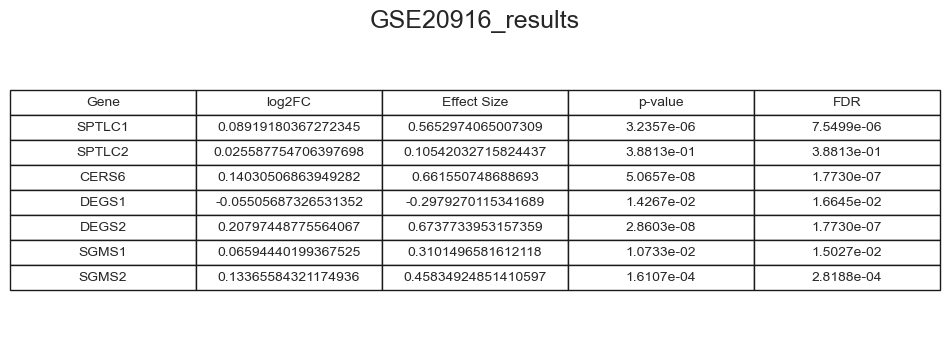

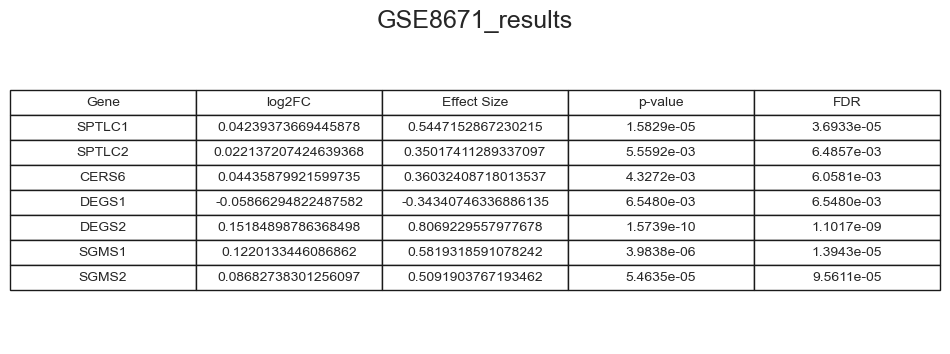

In [17]:
from matplotlib.font_manager import FontProperties

def export_table_as_pdf(df, filename):
    # Convert columns to scientific notation
    df[['p-value', 'FDR']] = df[['p-value', 'FDR']].applymap('{:.4e}'.format)

    fig, ax = plt.subplots(figsize=(12, 4)) # set size frame
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')
    
    # Adjust table
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1, 1.5)
    plt.title(filename.split(".")[0])
    
    # Bold row and column labels
    for (row, col), cell in the_table.get_celld().items():
        if (row == 0):
            cell.set_fontsize(10)
            #cell._text.set_fontproperties(FontProperties(weight='bold'))
        if (col == 0):
            cell.set_fontsize(10)
            #cell._text.set_fontproperties(FontProperties(weight='bold'))
    
    pdf_pages = matplotlib.backends.backend_pdf.PdfPages(filename)
    pdf_pages.savefig(fig, bbox_inches='tight')
    pdf_pages.close()

for dataset in ["GSE20916", "GSE8671"]:
    df = globals()[f'df_{dataset}_collapsed'].loc[genes_of_interest]
    info = globals()[f'info_{dataset}']
    result_df = calc_fc_and_fdr(df, info, genes_of_interest)
    print(f"Results for {dataset}:")
    print(result_df)
    print()
    export_table_as_pdf(result_df, f'{dataset}_results.pdf')


In [13]:
!conda list

# packages in environment at /home/jberg/miniconda3/envs/li_analysis:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alsa-lib                  1.2.8                h166bdaf_0    conda-forge
anyio                     3.7.0              pyhd8ed1ab_1    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py311hd4cff14_3    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attr                      2.5.1                h166bdaf_1    conda-forge
attrs                     23.1.0             pyh71513ae_1    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1a